In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Adım 1: Veriyi Okuma

In [88]:
# Dosya yolunu tanımlayın
file_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/batukar-com'

# Log verilerini listeye yükleme
logs = []
with open(file_path, 'r') as file:
    logs = [line.strip() for line in file.readlines()]

# İlk birkaç log kaydını yazdırarak kontrol edelim
print(f"Toplam log sayısı: {len(logs)}")
print("Örnek loglar:")
for log in logs[:5]:
    print(log)

Toplam log sayısı: 10
Örnek loglar:
217.131.103.132 - - [31/Dec/2024:04:15:21 +0300] "GET /favicon.ico HTTP/1.1" 404 1251 "http://batukar.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.2 Safari/605.1.15"
217.131.103.132 - - [31/Dec/2024:04:15:21 +0300] "GET /apple-touch-icon-precomposed.png HTTP/1.1" 404 1251 "-" "Safari/20620.1.16.11.8 CFNetwork/1568.300.101 Darwin/24.2.0"
217.131.103.132 - - [31/Dec/2024:04:15:21 +0300] "GET /apple-touch-icon.png HTTP/1.1" 404 1251 "-" "Safari/20620.1.16.11.8 CFNetwork/1568.300.101 Darwin/24.2.0"
217.131.103.132 - - [31/Dec/2024:04:15:21 +0300] "GET /cgi-sys/defaultwebpage.cgi HTTP/1.1" 200 1929 "http://batukar.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.2 Safari/605.1.15"
217.131.103.132 - - [31/Dec/2024:04:15:21 +0300] "GET /img-sys/server_misconfigured.png HTTP/1.1" 304 0 "http://batukar.com/cgi-sys/defaultwebpage.cgi" "Mozill

In [89]:
# Logların genel yapısını analiz etme
import re

# Örnek bir log formatını inceleme
example_log = logs[0]
log_pattern = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<timestamp>.*?)\] "(?P<method>.*?) (?P<url>.*?) (?P<protocol>.*?)" (?P<status>\d+) (?P<size>\d+|-)'
match = re.match(log_pattern, example_log)

if match:
    print("Log yapısı:")
    for key, value in match.groupdict().items():
        print(f"{key}: {value}")
else:
    print("Log formatı eşleşmedi.")

Log yapısı:
ip: 217.131.103.132
timestamp: 31/Dec/2024:04:15:21 +0300
method: GET
url: /favicon.ico
protocol: HTTP/1.1
status: 404
size: 1251


In [90]:

import random

# Sentetik veri üretim fonksiyonu
def generate_synthetic_data(df, target_size=10000):
    # Zaman damgasını datetime formatına dönüştürme
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['timestamp'])

    synthetic_data = df.copy()
    rows = []

    # Sentetik veri üretimi
    while len(synthetic_data) + len(rows) < target_size:
        for _, row in df.iterrows():
            manipulated_row = row.copy()
            manipulated_row['ip'] = f"{random.randint(1, 255)}.{random.randint(1, 255)}.{random.randint(1, 255)}.{random.randint(1, 255)}"
            manipulated_row['timestamp'] = manipulated_row['timestamp'] + pd.Timedelta(seconds=random.randint(1, 3600))
            manipulated_row['method'] = random.choice(["GET", "POST", "HEAD", "OPTIONS", "DELETE"])
            manipulated_row['status'] = random.choice(["200", "404", "500", "403", "302"])
            manipulated_row['url'] = manipulated_row['url'] + f"?query={random.randint(1, 100)}"
            rows.append(manipulated_row)

            if len(synthetic_data) + len(rows) >= target_size:
                break

    # Performans için tüm satırları birleştir
    synthetic_data = pd.concat([synthetic_data, pd.DataFrame(rows)], ignore_index=True)

    print(f"Sentetik veri üretildi: {len(synthetic_data)} kayıt.")
    return synthetic_data
    

In [101]:

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Sınıf dengesini sağlama fonksiyonu
def balance_classes_with_smote(df):
    if 'url' not in df.columns or 'label' not in df.columns:
        raise ValueError("DataFrame'de 'url' veya 'label' sütunu eksik!")

    # TF-IDF ile sayısallaştırma
    vectorizer = TfidfVectorizer(max_features=1000)
    X_numeric = vectorizer.fit_transform(df['url']).toarray()
    y = df['label']

    # SMOTE ile dengeleme
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_numeric, y)

    print(f"Sınıf dengesi sağlandı: {len(X_balanced)} kayıt.")
    return X_balanced, y_balanced
    

In [102]:

import re

# Log dosyasını yükleme ve ayrıştırma
def parse_log(log):
    log_pattern = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<timestamp>.*?)\] "(?P<method>.*?) (?P<url>.*?) (?P<protocol>.*?)" (?P<status>\d+) (?P<size>\d+|-)'
    match = re.match(log_pattern, log)
    return match.groupdict() if match else None

# Log dosyasını liste olarak yükleme
logs = []  # Log dosyanız burada listelenmeli

# Logları DataFrame'e dönüştürme
parsed_logs = [parse_log(log) for log in logs if parse_log(log)]
logs_df = pd.DataFrame(parsed_logs)

# Etiketleri ekleme
logs_df['label'] = logs_df['status'].apply(lambda x: 1 if x.startswith('4') or x.startswith('5') else 0)
    

                ip                 timestamp method  \
0  217.131.103.132 2024-12-31 04:15:21+03:00    GET   
1  217.131.103.132 2024-12-31 04:15:21+03:00    GET   
2  217.131.103.132 2024-12-31 04:15:21+03:00    GET   
3  217.131.103.132 2024-12-31 04:15:21+03:00    GET   
4  217.131.103.132 2024-12-31 04:15:21+03:00    GET   

                                 url  protocol status  size  
0                       /favicon.ico  HTTP/1.1    404  1251  
1  /apple-touch-icon-precomposed.png  HTTP/1.1    404  1251  
2              /apple-touch-icon.png  HTTP/1.1    404  1251  
3        /cgi-sys/defaultwebpage.cgi  HTTP/1.1    200  1929  
4  /img-sys/server_misconfigured.png  HTTP/1.1    304     0  


In [103]:

import random

# Sentetik veri üretim fonksiyonu
def generate_synthetic_data(df, target_size=10000):
    # Zaman damgasını datetime formatına dönüştürme
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['timestamp'])

    synthetic_data = df.copy()
    rows = []

    # Sentetik veri üretimi
    while len(synthetic_data) + len(rows) < target_size:
        for _, row in df.iterrows():
            manipulated_row = row.copy()
            manipulated_row['ip'] = f"{random.randint(1, 255)}.{random.randint(1, 255)}.{random.randint(1, 255)}.{random.randint(1, 255)}"
            manipulated_row['timestamp'] = manipulated_row['timestamp'] + pd.Timedelta(seconds=random.randint(1, 3600))
            manipulated_row['method'] = random.choice(["GET", "POST", "HEAD", "OPTIONS", "DELETE"])
            manipulated_row['status'] = random.choice(["200", "404", "500", "403", "302"])
            manipulated_row['url'] = manipulated_row['url'] + f"?query={random.randint(1, 100)}"
            rows.append(manipulated_row)

            if len(synthetic_data) + len(rows) >= target_size:
                break

    # Performans için tüm satırları birleştir
    synthetic_data = pd.concat([synthetic_data, pd.DataFrame(rows)], ignore_index=True)

    print(f"Sentetik veri üretildi: {len(synthetic_data)} kayıt.")
    return synthetic_data
    

In [105]:
# DataFrame'in sütunlarını kontrol etme
print("DataFrame sütunları:", logs_df.columns)

# İlk birkaç satırı kontrol etme
print(logs_df.head())

DataFrame sütunları: Index(['ip', 'timestamp', 'method', 'url', 'protocol', 'status', 'size'], dtype='object')
                ip                 timestamp method  \
0  217.131.103.132 2024-12-31 04:15:21+03:00    GET   
1  217.131.103.132 2024-12-31 04:15:21+03:00    GET   
2  217.131.103.132 2024-12-31 04:15:21+03:00    GET   
3  217.131.103.132 2024-12-31 04:15:21+03:00    GET   
4  217.131.103.132 2024-12-31 04:15:21+03:00    GET   

                                 url  protocol status  size  
0                       /favicon.ico  HTTP/1.1    404  1251  
1  /apple-touch-icon-precomposed.png  HTTP/1.1    404  1251  
2              /apple-touch-icon.png  HTTP/1.1    404  1251  
3        /cgi-sys/defaultwebpage.cgi  HTTP/1.1    200  1929  
4  /img-sys/server_misconfigured.png  HTTP/1.1    304     0  


In [107]:

import re

# Log dosyasını yükleme ve ayrıştırma
def parse_log(log):
    log_pattern = r'(?P<ip>\d+\.\d+\.\d+\.\d+) - - \[(?P<timestamp>.*?)\] "(?P<method>.*?) (?P<url>.*?) (?P<protocol>.*?)" (?P<status>\d+) (?P<size>\d+|-)'
    match = re.match(log_pattern, log)
    return match.groupdict() if match else None

# Log dosyasını liste olarak yükleme
logs = []  # Log dosyanız burada listelenmeli

# Logları DataFrame'e dönüştürme
parsed_logs = [parse_log(log) for log in logs if parse_log(log)]
logs_df = pd.DataFrame(parsed_logs)

# Etiketleri ekleme
logs_df['label'] = logs_df['status'].apply(lambda x: 1 if x.startswith('4') or x.startswith('5') else 0)
    

                ip                   timestamp method  \
0  217.131.103.132  31/Dec/2024:04:15:21 +0300    GET   
1  217.131.103.132  31/Dec/2024:04:15:21 +0300    GET   
2  217.131.103.132  31/Dec/2024:04:15:21 +0300    GET   
3  217.131.103.132  31/Dec/2024:04:15:21 +0300    GET   
4  217.131.103.132  31/Dec/2024:04:15:21 +0300    GET   

                                 url  protocol status  size  
0                       /favicon.ico  HTTP/1.1    404  1251  
1  /apple-touch-icon-precomposed.png  HTTP/1.1    404  1251  
2              /apple-touch-icon.png  HTTP/1.1    404  1251  
3        /cgi-sys/defaultwebpage.cgi  HTTP/1.1    200  1929  
4  /img-sys/server_misconfigured.png  HTTP/1.1    304     0  


In [108]:
# HTTP durum kodlarına göre etiketleme
logs_df['label'] = logs_df['status'].apply(lambda x: 1 if x.startswith('4') or x.startswith('5') else 0)

# Etiketlerin dağılımını kontrol etme
print("Etiket dağılımı:")
print(logs_df['label'].value_counts())

Etiket dağılımı:
label
0    6
1    4
Name: count, dtype: int64


In [110]:
# Zaman damgasını datetime formatına dönüştürme
logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')

# Hatalı dönüştürmeleri temizleme
logs_df = logs_df.dropna(subset=['timestamp'])

# İlk birkaç zaman damgasını kontrol etme
print(logs_df['timestamp'].head())

0   2024-12-31 04:15:21+03:00
1   2024-12-31 04:15:21+03:00
2   2024-12-31 04:15:21+03:00
3   2024-12-31 04:15:21+03:00
4   2024-12-31 04:15:21+03:00
Name: timestamp, dtype: datetime64[ns, UTC+03:00]


In [111]:

import random

# Sentetik veri üretim fonksiyonu
def generate_synthetic_data(df, target_size=10000):
    # Zaman damgasını datetime formatına dönüştürme
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df = df.dropna(subset=['timestamp'])

    synthetic_data = df.copy()
    rows = []

    # Sentetik veri üretimi
    while len(synthetic_data) + len(rows) < target_size:
        for _, row in df.iterrows():
            manipulated_row = row.copy()
            manipulated_row['ip'] = f"{random.randint(1, 255)}.{random.randint(1, 255)}.{random.randint(1, 255)}.{random.randint(1, 255)}"
            manipulated_row['timestamp'] = manipulated_row['timestamp'] + pd.Timedelta(seconds=random.randint(1, 3600))
            manipulated_row['method'] = random.choice(["GET", "POST", "HEAD", "OPTIONS", "DELETE"])
            manipulated_row['status'] = random.choice(["200", "404", "500", "403", "302"])
            manipulated_row['url'] = manipulated_row['url'] + f"?query={random.randint(1, 100)}"
            rows.append(manipulated_row)

            if len(synthetic_data) + len(rows) >= target_size:
                break

    # Performans için tüm satırları birleştir
    synthetic_data = pd.concat([synthetic_data, pd.DataFrame(rows)], ignore_index=True)

    print(f"Sentetik veri üretildi: {len(synthetic_data)} kayıt.")
    return synthetic_data
    

In [112]:

# Tüm süreci birleştirme
def process_data(df, target_size=10000):
    # Sentetik veri üretimi
    synthetic_data = generate_synthetic_data(df, target_size)

    # Sınıf dengesini sağlama
    X_balanced, y_balanced = balance_classes_with_smote(synthetic_data)

    return X_balanced, y_balanced

# Kullanım
X_balanced, y_balanced = process_data(logs_df, target_size=10000)
print(f"Sonuç: Dengeli veri boyutu: {len(X_balanced)}")
    

Sentetik veri üretildi: 10000 kayıt.
Sınıf dengesi sağlandı: 12000 kayıt.
Sonuç: Dengeli veri boyutu: 12000


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF kullanarak log verilerini sayısal forma dönüştürme
vectorizer = TfidfVectorizer(max_features=1000)  # Maksimum 1000 özellik çıkar
X_numeric = vectorizer.fit_transform(augmented_logs).toarray()

print(f"Sayısal özellik matrisi boyutu: {X_numeric.shape}")

Sayısal özellik matrisi boyutu: (1000, 1000)


In [114]:
print(f"X_numeric boyutu: {X_numeric.shape}")
print(f"Labels boyutu: {len(labels)}")

X_numeric boyutu: (1000, 1000)
Labels boyutu: 2


In [115]:
# Etiketleri yeniden oluşturma (örneğin: "404" -> Anomali (1), diğerleri -> Normal (0))
labels = [1 if "404" in log else 0 for log in augmented_logs]

print(f"Yeni labels boyutu: {len(labels)}")

Yeni labels boyutu: 1000


In [116]:
from imblearn.over_sampling import SMOTE

# SMOTE uygulama
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_numeric, labels)

print(f"Dengeli veri boyutu: {X_balanced.shape}")
print(f"Dengeli etiket boyutu: {len(y_balanced)}")

Dengeli veri boyutu: (1348, 1000)
Dengeli etiket boyutu: 1348


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [117]:
from collections import Counter

# Sınıf dağılımını yazdırma
print("Sınıf dağılımı (öncesi):", Counter(labels))
print("Sınıf dağılımı (sonrası):", Counter(y_balanced))

Sınıf dağılımı (öncesi): Counter({0: 674, 1: 326})
Sınıf dağılımı (sonrası): Counter({1: 674, 0: 674})


**Adım 3: Yeni Veriyi Dosyaya Kaydetme**

In [118]:
# Çoğaltılmış veriyi yeni bir dosyaya kaydetme
augmented_file_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/augmented_logs.txt'
with open(augmented_file_path, 'w') as file:
    file.write("\n".join(augmented_logs))

print(f"Çoğaltılmış veri kaydedildi: {augmented_file_path}")

Çoğaltılmış veri kaydedildi: /content/drive/MyDrive/Colab Notebooks/Datasets/augmented_logs.txt


**Adım 4: Yeni Veriyi Kontrol Edin**

In [119]:
# Çoğaltılmış dosyayı okuma
with open(augmented_file_path, 'r') as file:
    new_logs = [line.strip() for line in file.readlines()]

print(f"Yeni veri dosyasındaki toplam log sayısı: {len(new_logs)}")
print("Örnek log satırı:", new_logs[0])

Yeni veri dosyasındaki toplam log sayısı: 1000
Örnek log satırı: 217.131.103.132 - - [31/Dec/2024:04:15:21 +0300] "HEAD /file_74.html HTTP/1.1" 404 1251 "http://batukar.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.2 Safari/605.1.15"?utm_source=ad_22&utm_campaign=campaign_13#j8968


**Adım 5: Artırılmış Veri ile Model Eğitimi**

Adım 5.1: Yeni Veriyi Eğitim ve Test Setlerine Bölme

In [120]:
from sklearn.model_selection import train_test_split

# Yeni veriyi okuma
with open(augmented_file_path, 'r') as file:
    augmented_logs = [line.strip() for line in file.readlines()]

# Sınıfları belirleme (örnek: 404 kodlarını "Anomali" kabul ediyoruz)
def label_log(log):
    if "404" in log:
        return 1  # Anomali
    else:
        return 0  # Normal

# Logları ve etiketleri hazırlama
X = augmented_logs
y = [label_log(log) for log in augmented_logs]

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim seti boyutu: {len(X_train)}")
print(f"Test seti boyutu: {len(X_test)}")

Eğitim seti boyutu: 800
Test seti boyutu: 200


Adım 5.2: Veriyi Tokenize Etme

In [121]:
from transformers import BertTokenizer

# BERT Tokenizer yükleme
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Eğitim ve test setlerini tokenize etme
train_tokens = [tokenizer.encode_plus(
    log,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
) for log in X_train]

test_tokens = [tokenizer.encode_plus(
    log,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
) for log in X_test]

Adım 5.3: Tensor Formatına Dönüştürme

In [122]:
import torch

# Eğitim verileri
train_input_ids = torch.cat([x['input_ids'] for x in train_tokens], dim=0)
train_attention_masks = torch.cat([x['attention_mask'] for x in train_tokens], dim=0)
train_labels = torch.tensor(y_train)

# Test verileri
test_input_ids = torch.cat([x['input_ids'] for x in test_tokens], dim=0)
test_attention_masks = torch.cat([x['attention_mask'] for x in test_tokens], dim=0)
test_labels = torch.tensor(y_test)

Adım 5.4: Model Eğitimi

In [123]:
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, AdamW, get_scheduler
from tqdm import tqdm

# DataLoader oluşturma
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Modeli yükleme
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Öğrenme oranı planlayıcı
epochs = 4
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

# Modeli GPU'ya taşıma
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Eğitim döngüsü
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_dataloader, desc="Training")
    for batch in progress_bar:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"Loss": loss.item()})

    print(f"Ortalama Eğitim Kaybı: {total_loss / len(train_dataloader):.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4


Training: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s, Loss=0.124]


Ortalama Eğitim Kaybı: 0.3992
Epoch 2/4


Training: 100%|██████████| 50/50 [00:04<00:00, 11.40it/s, Loss=0.0126]


Ortalama Eğitim Kaybı: 0.1001
Epoch 3/4


Training: 100%|██████████| 50/50 [00:04<00:00, 11.43it/s, Loss=0.00943]


Ortalama Eğitim Kaybı: 0.0175
Epoch 4/4


Training: 100%|██████████| 50/50 [00:04<00:00, 11.44it/s, Loss=0.00568]

Ortalama Eğitim Kaybı: 0.0138


Adım 5.5: Performans Değerlendirmesi

In [124]:
# Test setini değerlendirme
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        total_correct += (predictions == b_labels).sum().item()
        total_samples += b_labels.size(0)

accuracy = total_correct / total_samples
print(f"Model Doğruluğu: {accuracy:.4f}")

Model Doğruluğu: 1.0000


**Adım 6: Model Performansının Detaylı Değerlendirilmesi**

Adım 6.1: Karmaşıklık Matrisi ve Sınıflandırma Raporu

In [125]:
from sklearn.metrics import confusion_matrix, classification_report

# Tahminler
all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

# Karmaşıklık matrisi
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:\n", cm)

# Sınıflandırma raporu
report = classification_report(all_labels, all_predictions, target_names=["Normal", "Anomali"], zero_division=0)
print("Classification Report:\n", report)

Confusion Matrix:
 [[132   0]
 [  0  68]]
Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       132
     Anomali       1.00      1.00      1.00        68

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



Adım 6.2: Karmaşıklık Matrisi Görselleştirme

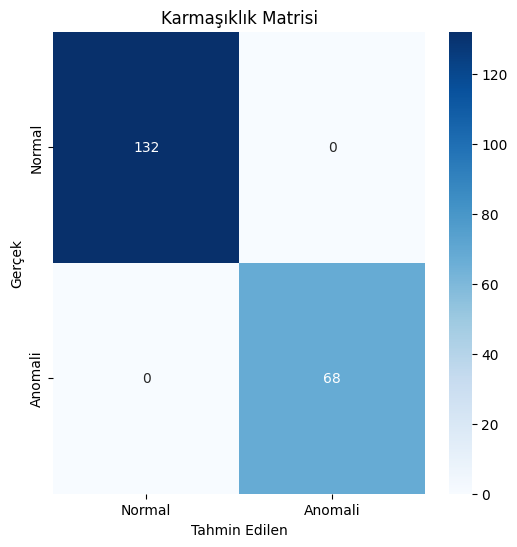

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Karmaşıklık matrisini görselleştirme
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomali"], yticklabels=["Normal", "Anomali"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karmaşıklık Matrisi")
plt.show()

Adım 6.3: Precision, Recall ve F1-Score Görselleştirme

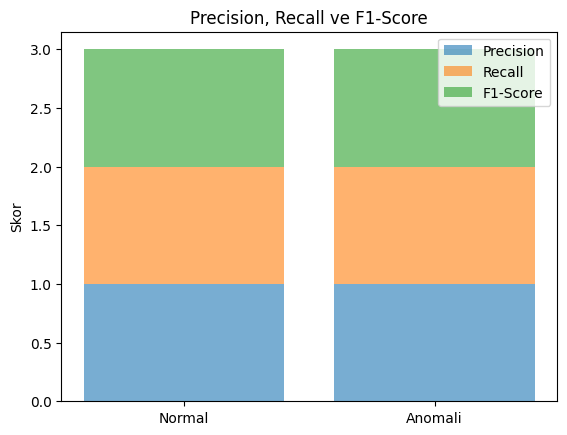

In [127]:
from sklearn.metrics import precision_recall_fscore_support

# Precision, Recall ve F1-Score hesaplama
metrics = precision_recall_fscore_support(all_labels, all_predictions, average=None)
precision, recall, f1_score = metrics[0], metrics[1], metrics[2]

# Görselleştirme
x = ["Normal", "Anomali"]
plt.bar(x, precision, alpha=0.6, label="Precision")
plt.bar(x, recall, alpha=0.6, label="Recall", bottom=precision)
plt.bar(x, f1_score, alpha=0.6, label="F1-Score", bottom=[p + r for p, r in zip(precision, recall)])

plt.legend()
plt.title("Precision, Recall ve F1-Score")
plt.ylabel("Skor")
plt.show()

Adım 6.4: Tahmin Sonuçlarının Örnek Analizi

In [128]:
# Örnek loglar üzerinde tahmin
example_logs = ["GET /favicon.ico HTTP/1.1", "POST /login HTTP/1.1"]  # Örnek loglar
example_tokens = [tokenizer.encode_plus(
    log,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
) for log in example_logs]

# Tensor formatına dönüştürme
example_input_ids = torch.cat([token['input_ids'] for token in example_tokens], dim=0).to(device)
example_attention_masks = torch.cat([token['attention_mask'] for token in example_tokens], dim=0).to(device)

# Tahmin yapma
model.eval()
with torch.no_grad():
    example_outputs = model(input_ids=example_input_ids, attention_mask=example_attention_masks)
    example_predictions = torch.argmax(example_outputs.logits, dim=1)

# Tahmin sonuçlarını yazdırma
for log, prediction in zip(example_logs, example_predictions):
    print(f"Log: {log} --> Tahmin: {'Anomali' if prediction.item() == 1 else 'Normal'}")

Log: GET /favicon.ico HTTP/1.1 --> Tahmin: Normal
Log: POST /login HTTP/1.1 --> Tahmin: Normal


**Adım 7: Modelin Gerçek Hayatta Kullanımı**

Adım 7.1: Gerçek Log Verileri ile Tahmin

In [129]:
# Yeni log verileri
real_logs = [
    "GET /home HTTP/1.1",
    "POST /admin HTTP/1.1",
    "GET /favicon.ico HTTP/1.1",
    "GET /nonexistent-page HTTP/1.1",  # Anomalik bir örnek
    "HEAD /contact HTTP/1.0"
]

# Tokenize etme
real_tokens = [tokenizer.encode_plus(
    log,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
) for log in real_logs]

# Tensor formatına dönüştürme
real_input_ids = torch.cat([token['input_ids'] for token in real_tokens], dim=0).to(device)
real_attention_masks = torch.cat([token['attention_mask'] for token in real_tokens], dim=0).to(device)

# Model tahminleri
model.eval()
with torch.no_grad():
    real_outputs = model(input_ids=real_input_ids, attention_mask=real_attention_masks)
    real_predictions = torch.argmax(real_outputs.logits, dim=1)

# Sonuçları yazdırma
for log, prediction in zip(real_logs, real_predictions):
    print(f"Log: {log} --> Tahmin: {'Anomali' if prediction.item() == 1 else 'Normal'}")

Log: GET /home HTTP/1.1 --> Tahmin: Normal
Log: POST /admin HTTP/1.1 --> Tahmin: Normal
Log: GET /favicon.ico HTTP/1.1 --> Tahmin: Normal
Log: GET /nonexistent-page HTTP/1.1 --> Tahmin: Normal
Log: HEAD /contact HTTP/1.0 --> Tahmin: Normal


Adım 7.2: Tahmin Sonuçlarının Analizi

Adım 7.3: Tahmin Dağılımının Görselleştirilmesi

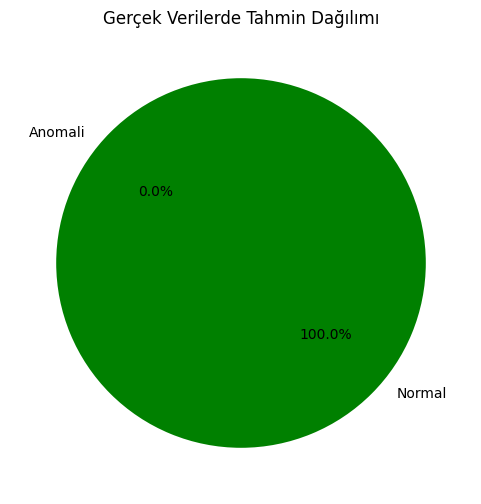

In [130]:
import matplotlib.pyplot as plt

# Tahminlerin sınıf dağılımını hesaplama
real_pred_counts = [sum(real_predictions.cpu().numpy() == 0), sum(real_predictions.cpu().numpy() == 1)]
labels = ['Normal', 'Anomali']

# Pasta grafiği
plt.figure(figsize=(6, 6))
plt.pie(real_pred_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['green', 'red'])
plt.title("Gerçek Verilerde Tahmin Dağılımı")
plt.show()

Adım 7.4: Yeni Veriler için Anomali Tespiti

In [85]:
# Tek bir log üzerinde test
new_log = "GET /nonexistent-file HTTP/1.1"

# Tokenize etme
new_token = tokenizer.encode_plus(
    new_log,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

new_input_ids = new_token['input_ids'].to(device)
new_attention_mask = new_token['attention_mask'].to(device)

# Tahmin
model.eval()
with torch.no_grad():
    new_output = model(input_ids=new_input_ids, attention_mask=new_attention_mask)
    new_prediction = torch.argmax(new_output.logits, dim=1)

print(f"Log: {new_log} --> Tahmin: {'Anomali' if new_prediction.item() == 1 else 'Normal'}")

Log: GET /nonexistent-file HTTP/1.1 --> Tahmin: Normal


Adım 7: Model Performansının Sonuçlarını Analiz Etme

Adım 7.1: Model Performansının Yorumlanması